<a href="https://colab.research.google.com/github/debtrinar/Bengali-to-english-language-translation-using-nmt/blob/main/Bengali_to_EnglishTranslationUsingNMTWithAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install tensorflow-text
!pip install einops

In [ ]:
import numpy as np

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm

import tensorflow as tf
import tensorflow_text as tf_text

from google.colab import drive

from sklearn.model_selection import train_test_split

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [ ]:
#@title
class ShapeChecker:
  def __init__(self):
    # Keep a cache of every axis-name seen.
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
Does Tom need my help?	টমের কি আমার সাহায্য দরকার?	CC-BY 2.0 (France) Attribution: tatoeba.org #8828162 (CK) & #11483501 (robingaspi)
```

They have a variety of languages available, but this example uses the English-Bengali dataset.

### Fetch and prepare the dataset

Define the paths to import the English-Bengali dataset from Google Drive. Additionally, a cleaned-up version of the dataset is created with just the text in English and Bengali and the attribution removed. The new, cleaned English-Bengali dataset will be saved in the same folder on Google Drive as the dataset. Here are the steps that need to be taken to prepare the data after cleaning the dataset.

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [ ]:
# Import the dataset from Google Drive.
drive.mount('/content/drive')

# Define the file paths for the training data and its cleaned-up version.
input_train_file_path = '/content/drive/MyDrive/Datasets/Anki/ben-eng/ben-eng.txt'
cleaned_train_file_path = '/content/drive/MyDrive/Datasets/Anki/ben-eng/cleaned.ben-eng.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def clean_translation_file(input_file_path, cleaned_file_path):
  with open(input_file_path, 'r', encoding='utf-8') as infile, open(cleaned_file_path, 'w', encoding='utf-8') as outfile:
      for line in infile:
          # Split the line by tab and take the first two parts (English and Bengali).
          parts = line.split('\t')
          if len(parts) >= 2:
              english = parts[0].strip()
              bengali = parts[1].strip()
              # Write the cleaned line to the output file.
              outfile.write(f"{english}\t{bengali}\n")

In [ ]:
clean_translation_file(input_train_file_path, cleaned_train_file_path)

In [ ]:
def load_data(input_file_path):
  with open(input_file_path, 'r', encoding='utf-8') as infile:
      lines = infile.read().splitlines()
      pairs = [line.split('\t')[:2] for line in lines]  # Ensure we only take the first two elements.

      context = np.array([context for target, context in pairs])
      target = np.array([target for target, context in pairs])

  return target, context

Load the dataset using `load_data` and review the lengths of the raw context and target variables. Print the first five context and target sequences.

In [ ]:
target_raw, context_raw = load_data(input_train_file_path)

print("Length of target_raw:", len(target_raw))
print("Length of context_raw:", len(context_raw))

print(target_raw[-1])
print(context_raw[-1])

print(f"Target:\n{target_raw[:5]}")
print(f"Context:\n{context_raw[:5]}")

Length of target_raw: 6509
Length of context_raw: 6509
January, February, March, April, May, June, July, August, September, October, November and December are the twelve months of the year.
বছরের বারোটা মাস হলো জানুয়ারি, ফেব্রুয়ারি, মার্চ, এপ্রিল, মে, জুন জুলাই, আগস্ট, সেপ্টেম্বর, অক্টোবর, নভেম্বর আর ডিসেম্বর।
Target:
['Go.' 'Go.' 'Go.' 'Run!' 'Run!']
Context:
['যাও।' 'যান।' 'যা।' 'পালাও!' 'পালান!']


### Create a tf.data dataset

From these arrays of strings you can create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) of strings that shuffles and batches them efficiently:

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

source_train, source_val, target_train, target_val = train_test_split(
    context_raw,
    target_raw,
    test_size=0.2,  # 20% of the data for validation.
    random_state=42  # For reproducibility.
)

train_raw = tf.data.Dataset.from_tensor_slices((source_train, target_train))
train_raw = train_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_raw = tf.data.Dataset.from_tensor_slices((source_val, target_val))
val_raw = val_raw.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
example_context = None
example_target = None

for example_context_strings, example_target_strings in train_raw.take(1):

  example_context = example_context_strings

  # Loop through the tensors in example_context_strings.
  for text_tensor in example_context[:5]:
      # Convert each tensor to a numpy array, decode, and print.
      print(text_tensor.numpy().decode())

  print()  # Print a new line for separation.

  example_target = example_target_strings

  # Loop through the tensors in example_target_strings.
  for text_tensor in example_target[:5]:
      # Convert each tensor to a numpy array, decode, and print.
      print(text_tensor.numpy().decode())

  break

আমায় কী পরিবর্তন করতে হবে?
আমার মনে হয় না টম এখানে ছিল।
গতকাল আমি আমার চায়ে মধু দিয়েছিলাম।
তিনি খাচ্ছেন।
কোনো সন্দেহ নেই।

What do I have to change?
I don't think that Tom was here.
Yesterday, I put honey in my tea.
He is eating.
There is no doubt.


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a [`tf.saved_model`](https://www.tensorflow.org/api_docs/python/tf/saved_model). To make that exported model useful it should take [`tf.string`](https://www.tensorflow.org/api_docs/python/tf#string) inputs, and return [`tf.string`](https://www.tensorflow.org/api_docs/python/tf#string) outputs: All the text processing happens inside the model. Mainly using a [`layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [ ]:
example_text = tf.constant('আমি ভালো আছি।')

print(example_text.numpy().decode())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy().decode())

আমি ভালো আছি।
আমি ভালো আছি।


Unicode normalization will be the first step in the text standardization function. As mentioned earlier, given that the Bengali characters and scripts are very different from English characters, the functions `tf_lower_and_split_punct_bengali` and `tf_lower_and_split_punct_english` have been used to standardize the Bengali and English text sequences, respectively.

In [ ]:
def tf_lower_and_split_punct_bengali(text):
    # Normalize UTF-8 text.
    text = tf_text.normalize_utf8(text, 'NFKD')

    # Filtering Bengali script characters, digits, spaces, and some basic punctuation.
    # The regex range for Bengali script is '\u0980-\u09FF'.
    # Retain some common punctuation marks.
    text = tf.strings.regex_replace(text, '[^ \u0980-\u09FF.?!,।]', '')

    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,।]', r' \g<0> ')

    # Strip whitespace.
    text = tf.strings.strip(text)

    # Add START and END tokens.
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

    return text

In [ ]:
def tf_lower_and_split_punct_english(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')

  # Convert text to lowercase.
  text = tf.strings.lower(text)

  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')

  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')

  # Strip whitespace.
  text = tf.strings.strip(text)

  # Add START and END tokens.
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct_bengali(example_text).numpy().decode())

আমি ভালো আছি।
[START] আমি ভালো আছি [END]


#### Text Vectorization

This standardization function will be wrapped up in a [`tf.keras.layers.TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct_bengali,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like [`Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit). This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'আমি', 'টম', 'না', 'আমার', 'কি', 'আপনি']

That's the Bengali `TextVectorization` layer, now build and `.adapt()` the English one:

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct_english,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'i', '?', 'you', 'tom', 'to']

Now these layers can convert a batch of strings into a batch of token IDs:

In [ ]:
example_tokens = context_text_processor(example_context)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 356, 22, 598, 14, 33, 3], [2, 7, 27, 29, 6, 5, 32, 49, 3],
 [2, 250, 4, 7, 3306, 1381, 1582, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] আমায় কী পরিবর্তন করতে হবে [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

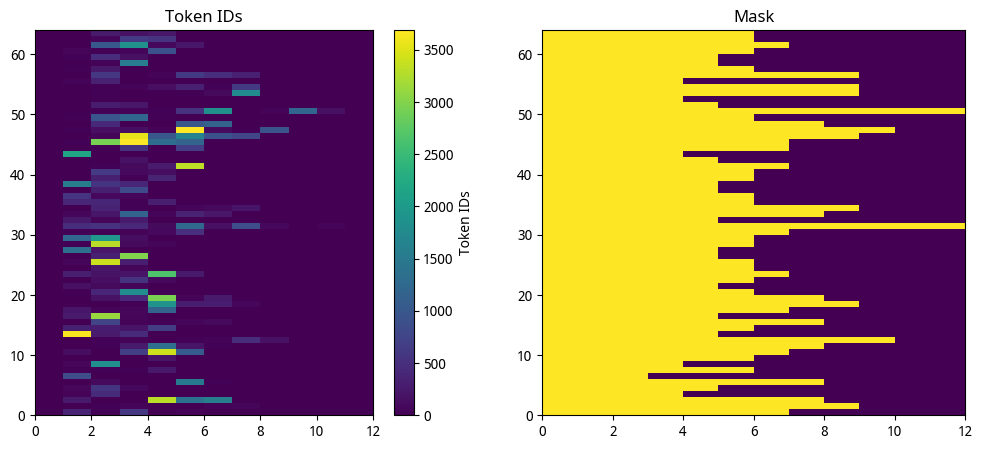

In [ ]:
# Create a colormap and normalization.
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(example_tokens.to_tensor()).numpy())

# Plot the token IDs.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Plot with pcolormesh for token IDs.
c = plt.pcolormesh(example_tokens.to_tensor(), cmap=cmap, norm=norm)
plt.title('Token IDs')

# Create a colorbar.
cbar = plt.colorbar(c, ax=plt.gca())
cbar.set_label('Token IDs')

# Plot with pcolormesh for the mask.
plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

plt.show()

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit). Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

In [ ]:
# Automatically tune the buffer size for optimal data loading performance.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_raw
    .cache()
    .map(process_text, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_raw
    .cache()
    .map(process_text, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)

Here is the first sequence of each, from the first batch:

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2   4 428 224   3   0   0   0   0   0]

[  2  24 533 235   4   0   0   0   0   0]
[ 24 533 235   4   3   0   0   0   0   0]


## The encoder/decoder

At each time-step the decoder's output is combined with the encoder's output, to predict the next word.

The original paper - [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5), contains a few extra connections that are intentionally omitted from this tutorial's model, as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

Before getting into it define constants for the model:

In [ ]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a [`layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)).
4. Processes the embeddings into a new sequence (Using a bidirectional [`layers.GRU`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)).
5. Returns the processed sequence. This will be passed to the attention head.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors.
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state.
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 12)
Encoder output, shape (batch, s, units): (64, 12, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output.

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence ([`layers.GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens.
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 12, 256)
Target sequence, shape (batch, t, units): (64, 13, 256)
Attention result, shape (batch, t, units): (64, 13, 256)
Attention weights, shape (batch, t, s):    (64, 13, 12)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 0.9999999 , 1.        , 1.        ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 ], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

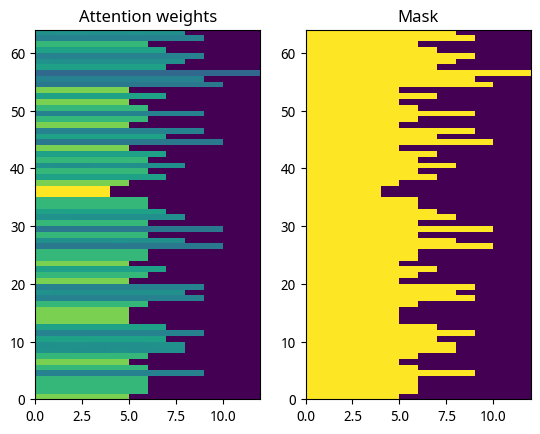

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors.
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state.

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings.
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token.

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 12, 256)
input target tokens shape: (batch, t) (64, 13)
logits shape shape: (batch, target_vocabulary_size) (64, 13, 2430)


#### Inference

To use it for inference you'll need a couple more methods:

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True)

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`.
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

With those extra functions, you can write a generation loop:

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t).

# Convert the tokens back to a string.
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'volleyball island hed school london complaining sleepy suggesting independent football',
       b'ups unfinished  prepared lose shape tshirt roses celebrating shortest',
       b'deny feel downloaded nearby universe cursing remember pain airlines members'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder.
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 12)
Target tokens, shape: (batch, t) (64, 13)
logits, shape: (batch, t, target_vocabulary_size) (64, 13, 2430)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 7.7956467, 'expected_acc': 0.00041152263374485596}

That should roughly match the values returned by running a few steps of evaluation:

In [ ]:
# Evaluate the model in terms of the loss and accuracy on the validation data.
results = model.evaluate(val_ds, steps=20, return_dict=True)

# Extract loss and accuracy from the dictionary 'results'.
val_loss = results['masked_loss']
val_accuracy = results['masked_acc']

print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

20/20 [==============================] - 7s 32ms/step - loss: 7.7983 - masked_acc: 5.6466e-04 - masked_loss: 7.7983
Validation Loss:  7.798253059387207
Validation Accuracy:  0.0005646570352837443


In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 19s 83ms/step - loss: 4.3986 - masked_acc: 0.3266 - masked_loss: 4.3920 - val_loss: 3.4498 - val_masked_acc: 0.4374 - val_masked_loss: 3.4498
Epoch 2/100
100/100 [==============================] - 8s 84ms/step - loss: 2.7436 - masked_acc: 0.5134 - masked_loss: 2.7407 - val_loss: 2.7807 - val_masked_acc: 0.5286 - val_masked_loss: 2.7807
Epoch 3/100
100/100 [==============================] - 8s 84ms/step - loss: 1.8313 - masked_acc: 0.6372 - masked_loss: 1.8291 - val_loss: 2.3963 - val_masked_acc: 0.5900 - val_masked_loss: 2.3963
Epoch 4/100
100/100 [==============================] - 8s 83ms/step - loss: 1.1727 - masked_acc: 0.7459 - masked_loss: 1.1709 - val_loss: 2.2952 - val_masked_acc: 0.6136 - val_masked_loss: 2.2952
Epoch 5/100
100/100 [==============================] - 8s 83ms/step - loss: 0.7343 - masked_acc: 0.8349 - masked_loss: 0.7303 - val_loss: 2.2531 - val_masked_acc: 0.6355 - val_masked_loss: 2.2531
Epoch 6/100
100/100

Evaluate the model's validation loss and accuracy after training.

In [ ]:
# Evaluate the model in terms of the loss and accuracy on the validation data.
results = model.evaluate(val_ds, steps=20, return_dict=True)

# Extract loss and accuracy from the dictionary 'results'.
val_loss = results['masked_loss']
val_accuracy = results['masked_acc']

print("Validation Loss: ", val_loss)
print("Validation Accuracy: ", val_accuracy)

20/20 [==============================] - 1s 32ms/step - loss: 2.3547 - masked_acc: 0.6571 - masked_loss: 2.3547
Validation Loss:  2.3547375202178955
Validation Accuracy:  0.6571348905563354


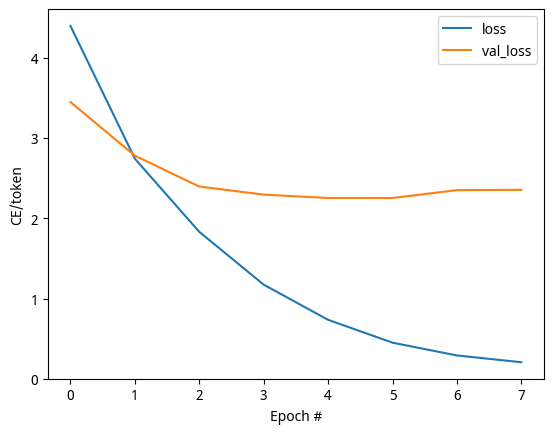

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

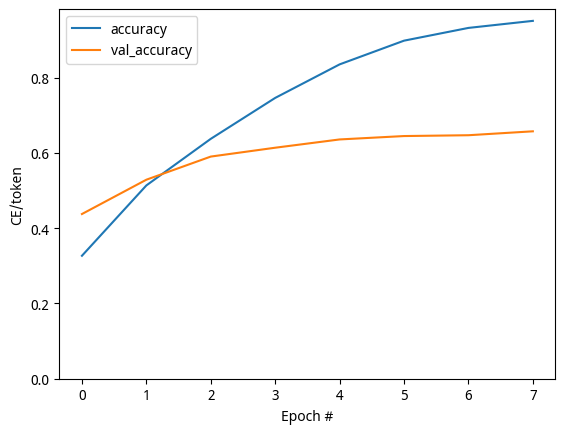

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the inference part of the subsection "The decoder", but this also captures the attention weights.

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts.
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs.
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token.
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens.
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch t).
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch t s).

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [ ]:
result = model.translate(['আমি বাড়িতে যাচ্ছি।']) # i am going home.
result[0].numpy().decode()

'im going to the house . '

Use that to generate the attention plot. However, in order to generate the attention plot, we also need to consider a font that can help display Bengali characters. We will use Noto Sans Bengali for the purpose. Let us go ahead and download the font and add it to Matplotlib for using it in our attention plots.

In [ ]:
# Path to the font file in Google Drive.
font_path = '/content/drive/MyDrive/Datasets/Anki/ben-eng/Fonts/NotoSansBengali-VariableFont_wdth,wght.ttf'

# Add the font to Matplotlib.
fm.fontManager.addfont(font_path)

# Set 'Noto Sans Bengali' as the font for serif text in plots.
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Noto Sans Bengali']})

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct_bengali(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct_english(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14, 'family': 'serif'}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-210-b10c59d84285>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-210-b10c59d84285>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


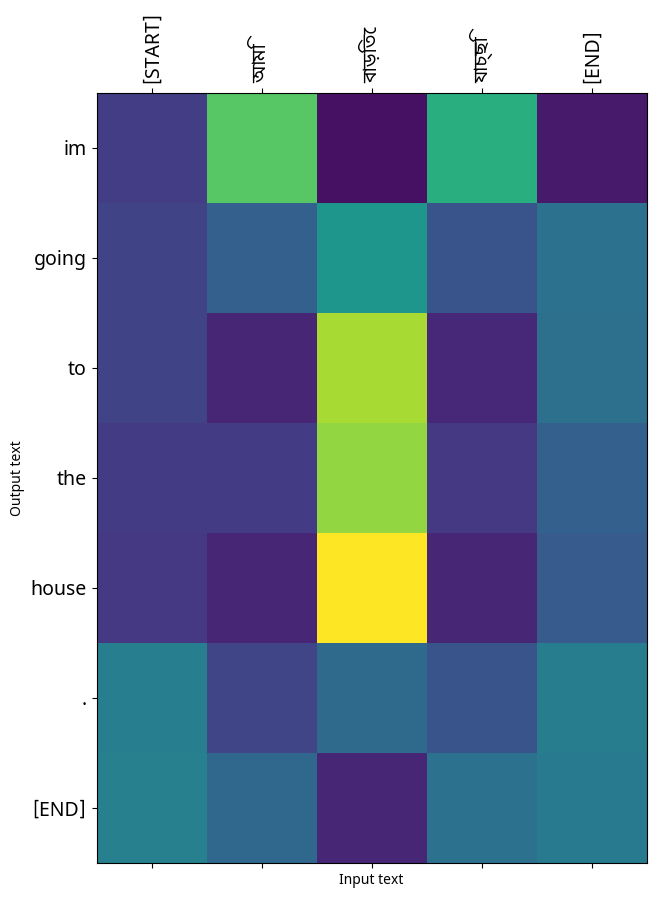

In [ ]:
model.plot_attention('আমি বাড়িতে যাচ্ছি।') # i am going home.

Translate a few more sentences and plot them:

<ipython-input-210-b10c59d84285>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-210-b10c59d84285>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 200 ms, sys: 109 ms, total: 309 ms
Wall time: 167 ms


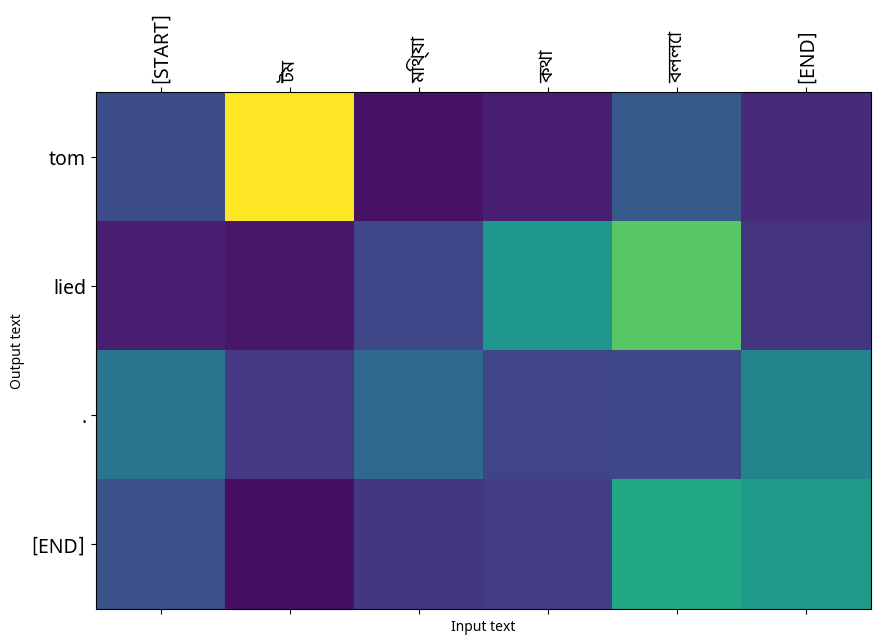

In [ ]:
%%time
# tom lied.
model.plot_attention('টম মিথ্যা কথা বললো।')

<ipython-input-210-b10c59d84285>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-210-b10c59d84285>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 222 ms, sys: 106 ms, total: 329 ms
Wall time: 196 ms


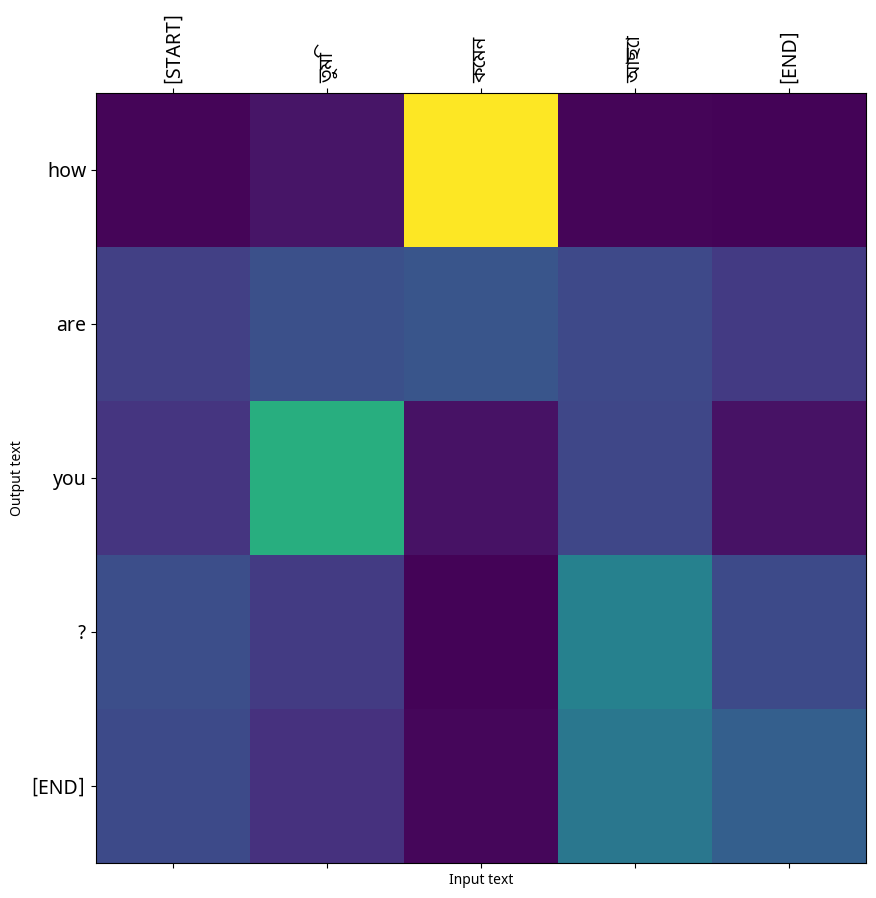

In [ ]:
%%time
# how are you?
model.plot_attention('তুমি কেমন আছো?')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](https://www.tensorflow.org/text/tutorials/transformer) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [ ]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 January, February, March, April, May, June, July, August, September,
October, November and December are the twelve months of the year.


<ipython-input-210-b10c59d84285>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-210-b10c59d84285>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


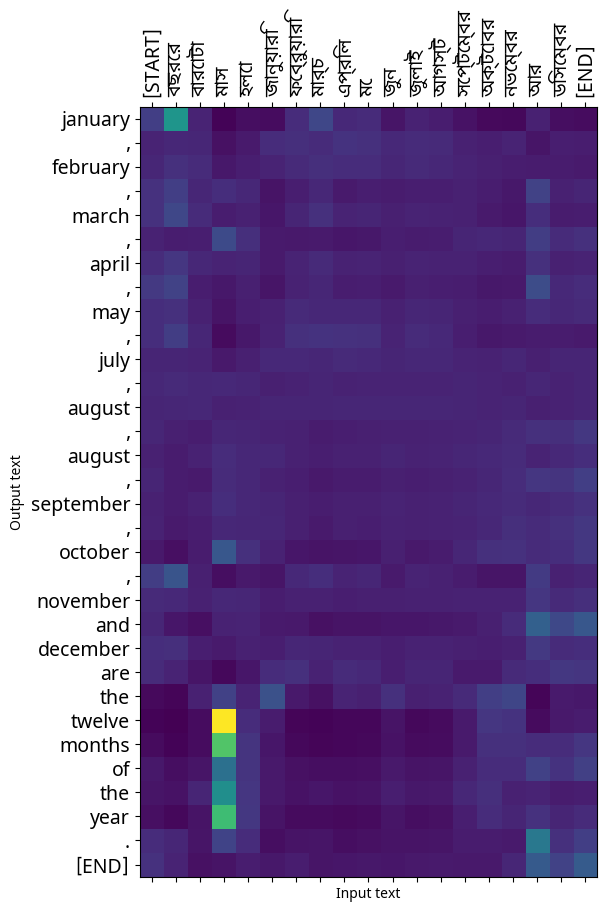

In [ ]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
inputs = [
    'আপনি কখন বাড়িতে পৌঁছাবেন?', # when will you reach home?
    'টম মিথ্যা কথা বললো।', # tom lied.
    'আমার প্রশ্নের জবাব দিন।' # answer me.
]

In [ ]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

when do you go home ? 
tom lied . 
answer me . 

CPU times: user 522 ms, sys: 44.1 ms, total: 566 ms
Wall time: 485 ms


In [ ]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ? 
tom lied .    
answer me .    

CPU times: user 235 ms, sys: 5.84 ms, total: 240 ms
Wall time: 228 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function). That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) once to compile it:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 2s, sys: 0 ns, total: 1min 2s
Wall time: 1min


In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ?                                            
tom lied .                                               
answer me .                                               

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 70 ms


Now that the function has been traced it can be exported using [`saved_model.save`](https://www.tensorflow.org/api_docs/python/tf/saved_model/save):

In [ ]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 12s, sys: 0 ns, total: 1min 12s
Wall time: 1min 12s


In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) # Warmup.

CPU times: user 48.2 s, sys: 0 ns, total: 48.2 s
Wall time: 46.1 s


In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ?                                            
tom lied .                                               
answer me .                                               

CPU times: user 215 ms, sys: 0 ns, total: 215 ms
Wall time: 69 ms


#### [Optional] Use a dynamic loop

It's worth noting that this initial implementation is not optimal. It uses a python loop:

```
for _ in range(max_length):
  ...
  if tf.executing_eagerly() and tf.reduce_all(done):
    break
```

The python loop is relatively simple but when [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) converts this to a graph, it **statically unrolls** that loop. Unrolling the loop has two disadvantages:

1. It makes `max_length` copies of the loop body. So the generated graphs take longer to build, save and load.
1. You have to choose a fixed value for the `max_length`.
1. You can't `break` from a statically unrolled loop. The [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function)
  version will run the full `max_length` iterations on every call.
  That's why the `break` only works with eager execution. This is
  still marginally faster than eager execution, but not as fast as it could be.


To fix these shortcomings, the `translate_dynamic` method, below, uses a tensorflow loop:

```
for t in tf.range(max_length):
  ...
  if tf.reduce_all(done):
      break
```

It looks like a python loop, but when you use a tensor as the input to a `for` loop (or the condition of a `while` loop) [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) converts it to a dynamic loop using operations like [`tf.while_loop`](https://www.tensorflow.org/api_docs/python/tf/while_loop).

There's no need for a `max_length` here it's just in case the model gets stuck generating a loop like: `the united states of the united states of the united states...`.

On the down side, to accumulate tokens from this dynamic loop you can't just append them to a python `list`, you need to use a [`tf.TensorArray`](https://www.tensorflow.org/api_docs/python/tf/TensorArray):

```
tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)
...
for t in tf.range(max_length):
    ...
    tokens = tokens.write(t, next_token) # next_token shape is (batch, 1)
  ...
  tokens = tokens.stack()
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
```

This version of the code can be quite a bit more efficient:

In [ ]:
#@title
@Translator.add_method
def translate_dynamic(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
  shape_checker = ShapeChecker()
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(context)[0]
  shape_checker(context, 'batch s units')

  next_token, done, state = self.decoder.get_initial_state(context)

  # Initialize the accumulator.
  tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

  for t in tf.range(max_length):
    # Generate the next token.
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done, state, temperature)
    shape_checker(next_token, 'batch 1')

    # Collect the generated tokens.
    tokens = tokens.write(t, next_token)

    # If all the sequences are done, break.
    if tf.reduce_all(done):
      break

  # Convert the list of generated token ids to a list of strings.
  tokens = tokens.stack()
  shape_checker(tokens, 't batch 1')
  tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
  shape_checker(tokens, 'batch t')

  text = self.decoder.tokens_to_text(tokens)
  shape_checker(text, 'batch')

  return text

With eager execution this implementation performs on par with the original:

In [ ]:
%%time
result = model.translate_dynamic(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ? 
tom lied .    
answer me .    

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 213 ms


But when you wrap it in a [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) you'll notice two differences.

In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate_dynamic(inputs)

In [ ]:
export = Export(model)

First, it's much quicker to trace, since it only creates one copy of the loop body:

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 6.96 s, sys: 0 ns, total: 6.96 s
Wall time: 6.72 s


The [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function) is much faster than running with eager execution, and on small inputs it's often several times faster than the unrolled version, because it can break out of the loop.

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ? 
tom lied .    
answer me .    

CPU times: user 56.5 ms, sys: 0 ns, total: 56.5 ms
Wall time: 18.3 ms


So save this version as well:

In [ ]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

CPU times: user 23.8 s, sys: 0 ns, total: 23.8 s
Wall time: 23.7 s


In [ ]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) # Warmup.

CPU times: user 12.8 s, sys: 0 ns, total: 12.8 s
Wall time: 10.9 s


In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

when do you go home ? 
tom lied .    
answer me .    

CPU times: user 53.2 ms, sys: 0 ns, total: 53.2 ms
Wall time: 16.4 ms


## Thoughts

The model has an accuracy of about 65%. The accuracy may slightly vary across separate occasions of training. However, it is important to note that this is a quick and dirty implementation of a very simple text translation model. Moreover, there is a limited amount of training data at our disposal. The results are not too bad based on those factors and can be considered about average. However, there is definitely a decent scope for improvement.

An important point to note is that the model loses attention when working with long sequences and falters with the translations. This is attributed to the model not being fed predictions from the previous time steps and the possibility of the RNN losing track of its context.

It can be observed that the model exhibits a high training accuracy and a lower validation accuracy. This is caused by overfitting, where the model essentially memorizes the training data and performs poorly on new, unseen data. This can in turn be attributed to the limited data available for training and inference. Overfitting can be controlled by leveraging more data (or by using data augmentation techniques) or by using a regularization technique, such as dropout or L2 regularization.

## Next steps

As indicated in the "Thoughts" section, there is a definite scope for improvement in this work. There are multiple ways to further develop this dirty implementation and improve the model's performance / accuracy for Bengali-to-English text translation. Some of those are listed below.

1.   **Modifying the Architecture:** Adding more layers, increasing the number of units in each layer, or using more attention heads and mechanisms can help the model learn more complex patterns. Using transformers can improve the performance by allowing the decoder to look at its previous outputs.
2.   **Vocabulary Size:** A larger vocabulary can help capture more nuances and meanings.
3.   **Hyperparameter Tuning:** Experimenting with different learning rates, batch sizes, epochs, etc. can help.
4.   **Regularization:** Implementing dropout or L2 regularization can be useful in controlling overfitting.
5.   **Enriching the Dataset:** Getting more data for training or using data augmentation techniques can help.
6.   **Pre-trained Embeddings:** Using pre-trained word embeddings like [FastText](https://fasttext.cc/) for Bengali and English can help improve the performance of the model.
7.   **Fine-tuning Pre-trained LLMs:** Using pre-trained LLMs trained on translation tasks using similar language pairs can be useful. Examples include [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert), [GPT-4](https://openai.com/index/gpt-4/), or similar models from the [Hugging Face Transformers library](https://huggingface.co/docs/transformers/en/index). Such models can significantly uplift the performance of word-based models.
8.   **Hyperparameter Optimization:** Using libraries, such as [Keras Tuner](https://keras.io/keras_tuner/) or [Optuna](https://optuna.org/) to find the best hyperparameters for the model.